In [10]:
import os
os.environ['DISPLAY'] = ':0.0'  # need for deepnet

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import cv2
from pyrender import Scene, Mesh, OffscreenRenderer, IntrinsicsCamera
from pyrender import SpotLight, OrthographicCamera, Node, DirectionalLight
from trimesh import Trimesh
np.set_printoptions(suppress=True)
plt.rcParams['figure.facecolor'] = 'white'

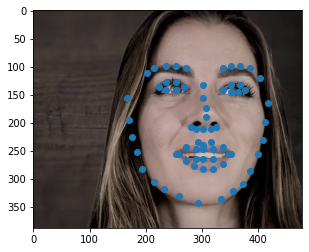

In [11]:
data = np.load('../fan_lm.npz')
v, img = data['v'], data['img']
tri = Delaunay(v[:, :2])
f_ =  tri.simplices
margin = 25
#h = int(v[:, 0].max()) - int(v[:, 0].min()) + margin * 2
#w = int(v[:, 1].max()) - int(v[:, 1].min()) + margin * 2
#v = v - v.min(axis=0) + margin

#img = np.zeros((w, h), dtype=np.uint8)
#for i in range(68):
#    cv2.circle(img, v[i, :2].astype(int), radius=2, color=(255, 0, 0), thickness=3)

#img = img[int(v[:, 1].min()):int(v[:, 1].max()), :]
#img = img[:, ]

#plt.imshow(img)

plt.imshow(img)
plt.scatter(v[:, 0], v[:, 1])
#plt.triplot(v[:,0], -v[:,1], tri.simplices)

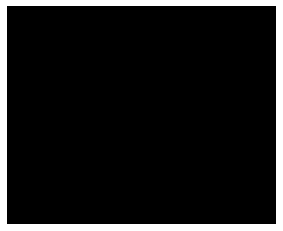

In [73]:
# Create pyrender-compatible mesh
data = np.load('../fan_lm.npz')
v, img = data['v'], data['img']
#v[:, 0] = data['v'][:, 1]
#v[:, 1] = data['v'][:, 0]
#v[:, 2] = v[:, 2] / img.shape[0]

#v[:, 0] = v[:, 0] / img.shape[1] - 0.5
#v[:, 1] = v[:, 1] / img.shape[0] - 0.5
#v[:, 2] = v[:, 2] / 500

nx, ny = img.shape[1], img.shape[0]
VP = np.array(
    [
        [nx / 2, 0, 0, (nx - 1) / 2],
        [0, -ny / 2, 0, (ny - 1) / 2],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ]
)

n = 0.05
f = 100.

OP = np.array(
    [
        [1 / (nx / ny), 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 2.0 / (n - f), (f + n) / (n - f)],
        [0, 0, 0, 1],
    ]
)

vw = np.c_[v, np.ones(v.shape[0])] @ np.linalg.inv(VP @ OP).T
vw[:, 2] = v[:, 2] / 10

mesh = Trimesh(vw[:, :3], f_)
#mesh = Trimesh(v, f_)
mesh_pr = Mesh.from_trimesh(mesh, wireframe=True)
#mesh_pr = Mesh.from_points(vw[:, :3])

# Create scene and add head
scene = Scene(bg_color=[0, 0, 0], ambient_light=(255, 255, 255))
head = Node(mesh=mesh_pr)
scene.add_node(head)

cam_mat = np.eye(4)
cam_mat[2, 3] = 100
#cam_mat[:3, 3] = vw.mean(axis=0)[:3]
#cam_mat = np.linalg.inv(cam_mat)
camera = Node(camera=OrthographicCamera(xmag=1, ymag=1, ), matrix=cam_mat)
v_ = np.c_[vw[:, :3], np.ones(vw.shape[0])] @ (VP @ OP).T
scene.add_node(camera)

# Create spotlight, directly in front of head (so need to translate)
# Also zoom out in z-direction
light = DirectionalLight(intensity=50)#SpotLight(intensity=50)
scene.add_node(Node(light=light))#, matrix=cam_mat))

# Create renderer with viewport of the same size as original image
r = OffscreenRenderer(viewport_width=img.shape[1], viewport_height=img.shape[0])
color, depth = r.render(scene)

#plt.imshow(img)
plt.imshow(color, alpha=1)
plt.axis('off');

In [74]:
v[:, 2]

array([ -88.72718  ,  -84.58379  ,  -80.87126  ,  -74.56702  ,
        -58.272682 ,  -30.361534 ,    1.8570255,   29.807812 ,
         41.01495  ,   23.539488 ,   -8.143218 ,  -42.228424 ,
        -71.343445 ,  -88.54547  ,  -96.136635 , -101.84803  ,
       -106.88625  ,   18.581892 ,   35.94265  ,   47.041695 ,
         53.70518  ,   56.309254 ,   51.521587 ,   46.670387 ,
         37.45709  ,   23.971819 ,    4.102239 ,   59.192574 ,
         73.873856 ,   90.79693  ,   94.48817  ,   63.61987  ,
         68.92553  ,   71.42438  ,   66.820625 ,   59.9893   ,
         32.18697  ,   43.808334 ,   43.263004 ,   38.1124   ,
         43.651077 ,   41.5437   ,   33.82659  ,   36.42973  ,
         34.229725 ,   20.253426 ,   31.544819 ,   36.667297 ,
         47.30788  ,   65.99764  ,   74.88618  ,   75.927444 ,
         73.49045  ,   60.142033 ,   37.319706 ,   53.540337 ,
         62.529453 ,   65.65418  ,   65.27273  ,   59.239372 ,
         47.157444 ,   68.736626 ,   70.86294  ,   66.2

(array([ 5.,  4.,  1.,  2.,  1.,  2.,  8., 20., 21.,  4.]),
 array([-0.21377251, -0.17349762, -0.13322274, -0.09294785, -0.05267297,
        -0.01239809,  0.0278768 ,  0.06815168,  0.10842656,  0.14870145,
         0.18897633]),
 <BarContainer object of 10 artists>)

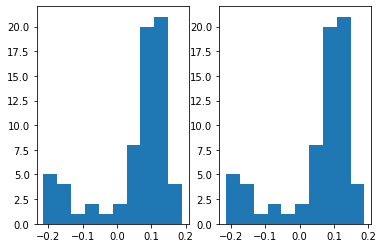

In [29]:
np.set_printoptions(suppress=True)
i = 2
plt.subplot(1, 2, 1)
plt.hist(v[:, i])

plt.subplot(1, 2, 2)
plt.hist(vw[:, i])

In [ ]:
#v_ = np.c_[vw[:, :3], np.ones(vw.shape[0])] @ (VP @ OP).T
plt.imshow(img)
#plt.scatter(v_[:, 0] + 195, v_[:, 1] + 195)
plt.scatter(v_[:, 0], v_[:, 1])

In [ ]:
#plt.figure(figsize=np.array(img.shape[:2]) / 50)
#plt.imshow(img)
#plt.scatter(v[:, 0], v[:, 1], c='r', s=10)
img = cv2.circle(img, (100, 100), color=(255, 0, 0), radius=100, thickness=10)
#tri = Delaunay(v)
#l, m = plt.triplot(v[:, 0], v[:, 1], tri.simplices)
plt.imshow(img)